In [165]:
from typing import Tuple

from shapely.geometry import LineString, MultiLineString, Point
import numpy as np
from matplotlib import pyplot as plt

### Create points for a spline

In [417]:
x = np.arange(0,20*np.pi,0.1)   # start,stop,step
y = 30-30*np.sin(x/30)

# x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
# y = np.array([0,0,0,0,0,0,0,0,1,2,3,4,5,6,7,8,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10])

### Create a shapely LineString from the points

In [418]:
linestring = LineString(np.vstack([x,y]).T)
points = [Point(10,15), Point(30,9), Point(55,0)]
headings = [10, 45, 39.7]
colors = ['ro', 'bo', 'go']

In [419]:
# Simulate lane edges, only for visualization
linestring_left = linestring.parallel_offset(5, 'left')
linestring_right = linestring.parallel_offset(5, 'right')

### Function to convert from cartesian to frenet

In [420]:
def get_frenet_from_cartesian(linestring : LineString, cartesian_point: Point, cartesian_heading: float = None, resolution: float = 0.01) -> Tuple[float, float, float, Point]:
    
    s = linestring.project(cartesian_point)
    d = linestring.distance(cartesian_point)
    
    closest_point_on_linestring = linestring.interpolate(s)
    
    local_section_of_spline_start = linestring.interpolate(max(0, s-resolution))
    local_section_of_spline_end = linestring.interpolate(min(linestring.length, s+resolution))
    local_section_heading_in_cartesian_coordinates = np.degrees(np.arctan2(local_section_of_spline_end.y-local_section_of_spline_start.y, local_section_of_spline_end.x - local_section_of_spline_start.x))
    heading_relative_to_local_section_heading = cartesian_heading - local_section_heading_in_cartesian_coordinates

    heading_of_line_joining_input_points_and_its_closest_point_on_linestring = np.degrees(np.arctan2(cartesian_point.y-closest_point_on_linestring.y, cartesian_point.x - closest_point_on_linestring.x))
    relative_heading = heading_of_line_joining_input_points_and_its_closest_point_on_linestring - local_section_heading_in_cartesian_coordinates
    if(relative_heading < 0 or relative_heading > 180):
        d = -1*d
    
    

    return s, d, heading_relative_to_local_section_heading, closest_point_on_linestring

### Function to convert from frenet to cartesian

In [421]:
def get_cartesian_from_frenet(linestring: LineString, frenet_point: np.ndarray, frenet_heading: float, resolution: float = 0.01) -> Tuple[float, float, float]:
    
    s = frenet_point[0]
    d = frenet_point[1]
    
    point_on_linestring = linestring.interpolate(s)
    local_section_of_spline_start = linestring.interpolate(max(0, s-resolution))
    local_section_of_spline_end = linestring.interpolate(min(linestring.length, s+resolution))
    local_section_heading_in_cartesian_coordinates = np.degrees(np.arctan2(local_section_of_spline_end.y-local_section_of_spline_start.y, local_section_of_spline_end.x - local_section_of_spline_start.x))
    
    angle_to_extend = (local_section_heading_in_cartesian_coordinates + 90)*np.pi/180
    cartesian_point = [point_on_linestring.x + d*np.cos(angle_to_extend), point_on_linestring.y + d*np.sin(angle_to_extend)]
    
    cartesian_heading = local_section_heading_in_cartesian_coordinates + frenet_heading
    
    return cartesian_point[0], cartesian_point[1], cartesian_heading
    

POINT (10 15)
x: 10.0 y: 15.0 heading: 10
s: 17.51021635379144 d: -3.7966484599243397 heading_frenet: 52.42003274845919 

POINT (30 9)
x: 30.0 y: 9.0 heading: 45
s: 37.18304298647992 d: 3.693686133905235 heading_frenet: 75.58872888824656 

POINT (55 0)
x: 55.0 y: 0.0 heading: 39.7
s: 65.01671702978474 d: -0.9959832392170908 heading_frenet: 25.584263764960255 



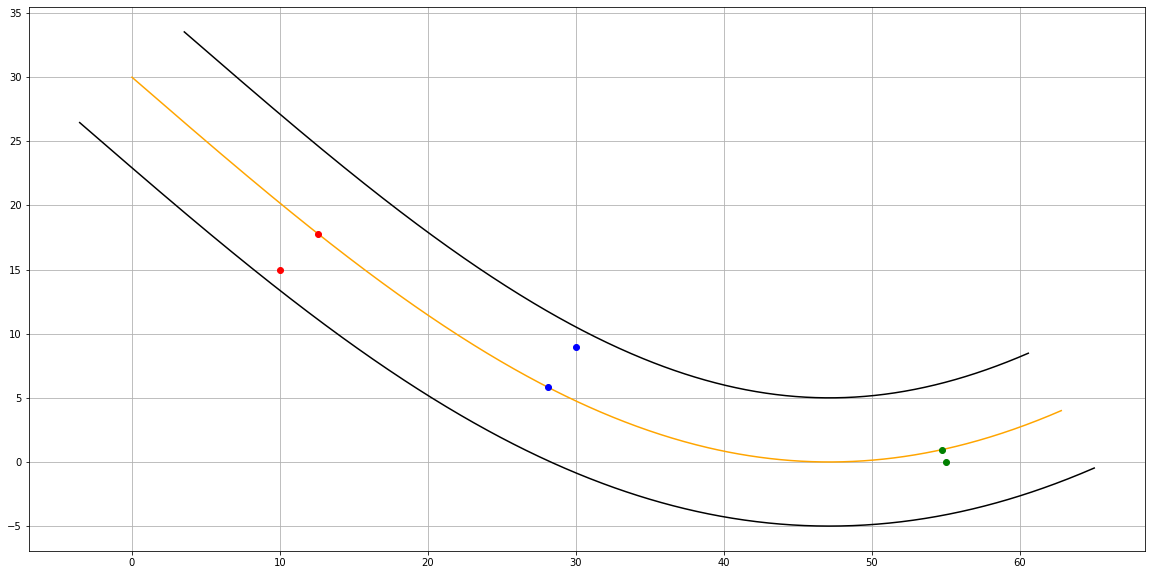

In [422]:
plt.figure(figsize = (20,10))
plt.plot(x,y,'orange')
plt.plot(np.asarray(linestring_left)[:,0],np.asarray(linestring_left)[:,1],'black')
plt.plot(np.asarray(linestring_right)[:,0],np.asarray(linestring_right)[:,1],'black')


for i,point in enumerate(points):
    plt.plot(point.x, point.y, colors[i])

    
for i,point in enumerate(points):
    s,d,heading,closest_point_on_linestring = get_frenet_from_cartesian(linestring, point, headings[i])
    plt.plot(closest_point_on_linestring.x, closest_point_on_linestring.y, colors[i])

    print(point.wkt)
    print("x:", point.x, "y:", point.y, "heading:", headings[i])
    print("s:", s, "d:", d, "heading_frenet:", heading,  "\n")
    
plt.grid()
plt.show()

### Example of projection back into cartesian frame

In [423]:
frenet_s = 65.01671702978474
frenet_d = -0.9959832392170908
frenet_heading = 25.584263764960255
cartesian_x, cartesian_y, cartesian_heading = get_cartesian_from_frenet(linestring, [frenet_s, frenet_d], frenet_heading)
print("Frenet s:", frenet_s, "\nFrenet d:", frenet_d, "\nFrenet Heading:", frenet_heading, "\n")
print("Cartesian x:", cartesian_x, "\nCartesian y:", cartesian_y, "\nCartesian Heading:", cartesian_heading)

Frenet s: 65.01671702978474 
Frenet d: -0.9959832392170908 
Frenet Heading: 25.584263764960255 

Cartesian x: 55.00000000000003 
Cartesian y: 6.772360450213455e-15 
Cartesian Heading: 39.7
